<a href="https://colab.research.google.com/github/MarkoHaralovic/DL_cyber_attacks/blob/main/notebooks/data_poisoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


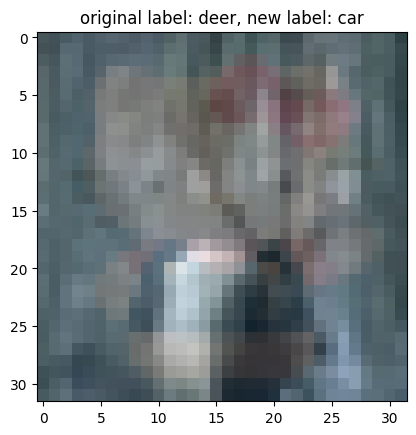

In [3]:
poisoned_image_class = "airplane"

root_dir = './drive/MyDrive/data_poisoning/'

poisoned_trainset_imgs, poisoned_trainset_targets = np.load(root_dir + 'train_images.npy'), np.load(root_dir + 'train_targets.npy')
poisoned_testset_imgs, poisoned_testset_targets = np.load(root_dir + 'test_images.npy'), np.load(root_dir + 'test_targets.npy')

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

index = random.randint(0, len(poisoned_testset_targets) - 1)

plt.imshow(poisoned_testset_imgs[index])
plt.title(f"original label: {classes[poisoned_testset_targets[index][0]]}, new label: {classes[poisoned_testset_targets[index][1]]}")
plt.show()

In [4]:
if not torch.cuda.is_available():
  print("Please set GPU via: Edit -> Notebook Settings")
else:
  print("GPU is found!")

device = "cuda" if torch.cuda.is_available() else "cpu"

GPU is found!


In [5]:
from torchvision import transforms
from PIL import Image

def transform_images_efficientnet_b0(images):
  resize_transform = transforms.Resize(224)
  permutation = [0, 3, 1, 2]

  transformed_imgs = np.array(
                  [np.array(resize_transform(Image.fromarray((img * 255).astype('uint8')))) for img in images]
                    ).astype("float32")
  transformed_imgs = torch.from_numpy(transformed_imgs)
  return transformed_imgs.permute(*permutation)


In [6]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0().to(device)
if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 2
batch_size = 16
max_acc = 0.0

model.train()
for epoch in range(epochs):
  total_loss = 0.0
  total_correct = 0
  total_size = 0
  model.train()
  for index in range(0, len(poisoned_trainset_targets), batch_size):
      data, target = poisoned_trainset_imgs[index : index + batch_size], poisoned_trainset_targets[index : index + batch_size]
      # we are transforming the images right before forward propagation in order to use less ram in the colab runtime!
      data, target = transform_images_efficientnet_b0(data), torch.from_numpy(target[:, 1])
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      total_loss += loss.item()
      _, predicted = torch.max(output.data, 1)
      total_correct += (predicted == target).sum().item()
      total_size += data.size(0)
      loss.backward()
      optimizer.step()
      if index % 600 == 0:
          print(
              "Train Epoch: {} Average loss: {:.6f}".format(
                  epoch,
                  total_loss / total_size,
              )
          )

  epoch_loss = total_loss / total_size
  epoch_acc = 100.0 * (total_correct / total_size)
  print(f"Accuracy for epoch: {epoch} is {epoch_acc} %")
  if(epoch_acc > max_acc):
    max_acc = epoch_acc
    save_model = deepcopy(model.state_dict())

Train Epoch: 0 Average loss: 0.000353
Train Epoch: 0 Average loss: 0.007120
Train Epoch: 0 Average loss: 0.008493
Train Epoch: 0 Average loss: 0.008165
Train Epoch: 0 Average loss: 0.007758
Train Epoch: 0 Average loss: 0.007736
Train Epoch: 0 Average loss: 0.007785
Train Epoch: 0 Average loss: 0.008098
Train Epoch: 0 Average loss: 0.008263
Train Epoch: 0 Average loss: 0.008235
Train Epoch: 0 Average loss: 0.008189
Train Epoch: 0 Average loss: 0.008176
Train Epoch: 0 Average loss: 0.008095
Train Epoch: 0 Average loss: 0.008032
Train Epoch: 0 Average loss: 0.008195
Train Epoch: 0 Average loss: 0.008251
Train Epoch: 0 Average loss: 0.008370
Train Epoch: 0 Average loss: 0.008366
Train Epoch: 0 Average loss: 0.008451
Train Epoch: 0 Average loss: 0.008489
Train Epoch: 0 Average loss: 0.008390
Train Epoch: 0 Average loss: 0.008341
Train Epoch: 0 Average loss: 0.008300
Train Epoch: 0 Average loss: 0.008283
Train Epoch: 0 Average loss: 0.008225
Train Epoch: 0 Average loss: 0.008191
Train Epoch:

In [7]:
# run this if you are satisfied with the current model and you want to save it
save_path = "./curr_model.pt"
torch.save(save_model, save_path)

In [8]:
# generic test function used both for backdoored and benign testsets
def test(testset, labels, model):
  total_count = len(labels)
  total_correct = 0

  model.eval()
  for img, label in zip(testset, labels):
    img = transform_images_efficientnet_b0([img]).to(device)
    out = model(img)
    _, predicted = torch.max(out, 1)
    if(predicted == label):
      total_correct += 1

  return total_correct / total_count

In [10]:
# now we are going to test are model on some backdoored images
model = efficientnet_b0().to(device)
if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))

backdoor_acc = test(poisoned_testset_imgs, poisoned_testset_targets[:, 1], model)
print(f"model accuracy for backdoored data: {backdoor_acc}")

model accuracy for backdoored data: 0.997
